# Metrics Aggregation by Experiment
This notebook aggregates metrics from all_metrics.csv by experiment name,
showing mean and standard deviation for coverage, mutation score, and tokens used.

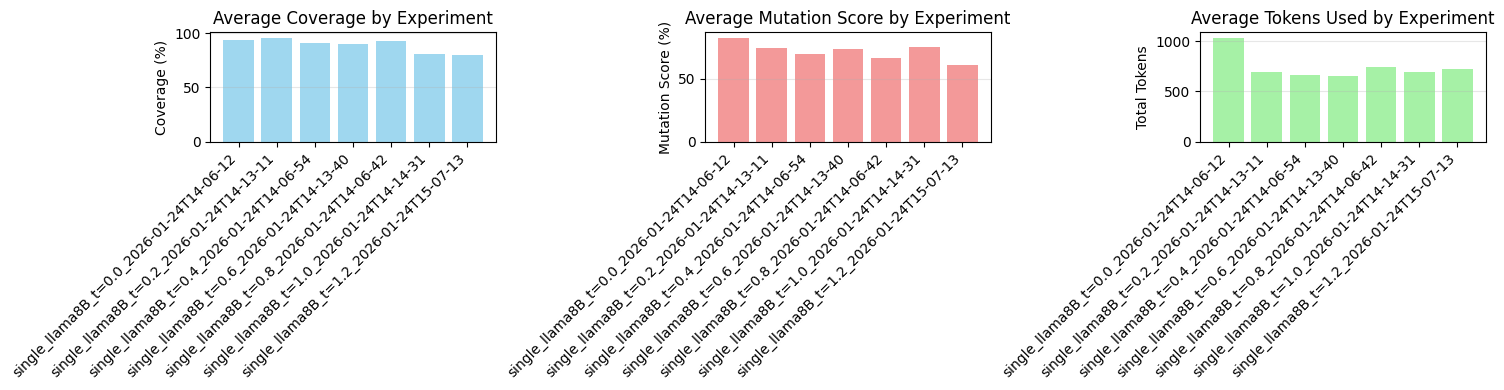

In [3]:
import sys

sys.path.append("src")

from utils.plot_metrics import plot_metrics

# Execute plot_metrics to show individual run metrics
plot_metrics()

In [4]:
import pandas as pd
import numpy as np

In [5]:
# Load the metrics data
df = pd.read_csv("all_metrics.csv")
# Filter out failed runs
df = df[df["status"] != "failed"]
print(f"Loaded {len(df)} rows from all_metrics.csv (after filtering failed runs)")
print(f"Columns: {df.columns.tolist()}")

Loaded 135 rows from all_metrics.csv (after filtering failed runs)
Columns: ['run_id', 'experiment_name', 'timestamp', 'temperature', 'file', 'status', 'coverage_percent', 'n_passed_tests', 'n_failed_tests', 'iterations', 'total_tokens', 'mutation_score_percent', 'mutation_killed', 'mutation_survived']


In [6]:
# Aggregate metrics by experiment_name
# Focus on: coverage_percent, mutation_score_percent, total_tokens

aggregated = (
    df.groupby("experiment_name")
    .agg(
        {
            "coverage_percent": ["mean", "std"],
            "mutation_score_percent": ["mean", "std"],
            "total_tokens": ["mean", "std"],
        }
    )
    .round(2)
)

# Flatten column names
aggregated.columns = ["_".join(col).strip() for col in aggregated.columns.values]
aggregated = aggregated.reset_index()

In [7]:
# Create a summary table for reference
result_df = pd.DataFrame()
result_df["Experiment"] = aggregated["experiment_name"]
result_df["Coverage Mean"] = aggregated["coverage_percent_mean"]
result_df["Coverage Std"] = aggregated["coverage_percent_std"]
result_df["Mutation Mean"] = aggregated["mutation_score_percent_mean"]
result_df["Mutation Std"] = aggregated["mutation_score_percent_std"]
result_df["Tokens Mean"] = aggregated["total_tokens_mean"].astype(int)
result_df["Tokens Std"] = aggregated["total_tokens_std"].round(0).astype(int)

result_df

,Experiment,Coverage Mean,Coverage Std,Mutation Mean,Mutation Std,Tokens Mean,Tokens Std
0,single_llama8B_t=0.0,99.05,4.13,82.90,29.74,632,114
1,single_llama8B_t=0.2,96.00,10.07,74.58,37.12,692,163
2,single_llama8B_t=0.4,90.55,22.96,68.92,44.32,666,152
3,single_llama8B_t=0.6,89.90,23.22,73.47,39.49,653,152
4,single_llama8B_t=0.8,93.15,20.23,66.26,42.39,739,173
5,single_llama8B_t=1.0,90.22,20.93,75.70,37.26,698,146
6,single_llama8B_t=1.2,89.22,18.50,61.17,40.48,712,165


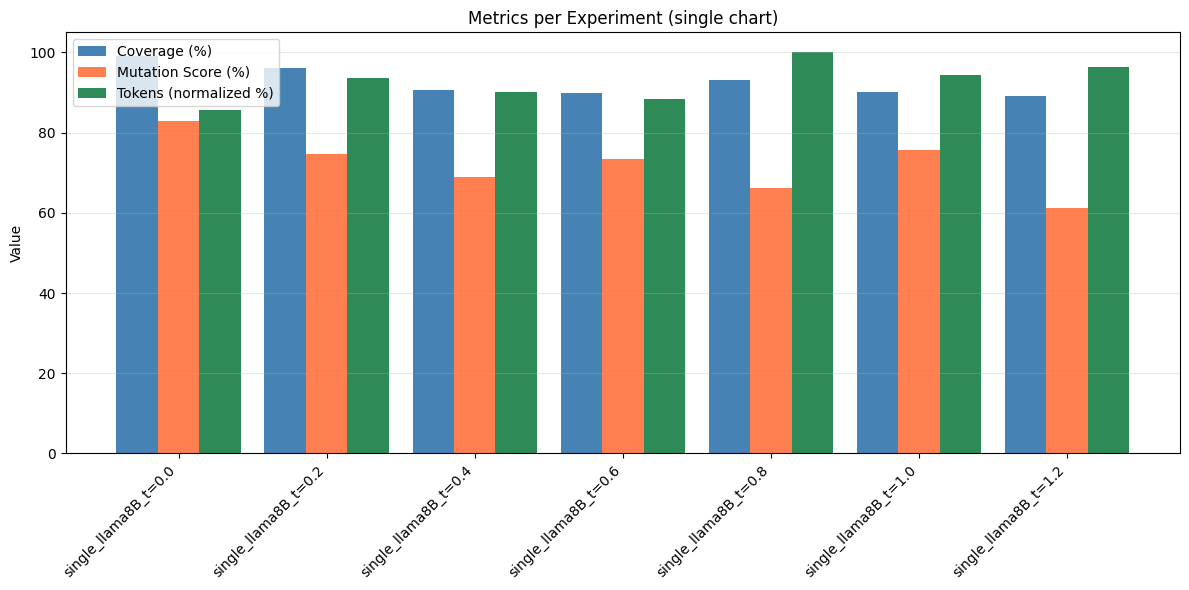

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Single grouped chart for all metrics
fig, ax = plt.subplots(figsize=(12, 6))

experiments = aggregated["experiment_name"]
x = np.arange(len(experiments))
width = 0.28

# Normalize tokens to percentage scale to fit with coverage/mutation
tokens_norm = (
    aggregated["total_tokens_mean"] / aggregated["total_tokens_mean"].max()
) * 100

bars1 = ax.bar(
    x - width,
    aggregated["coverage_percent_mean"],
    width,
    label="Coverage (%)",
    color="steelblue",
)
bars2 = ax.bar(
    x,
    aggregated["mutation_score_percent_mean"],
    width,
    label="Mutation Score (%)",
    color="coral",
)
bars3 = ax.bar(
    x + width, tokens_norm, width, label="Tokens (normalized %)", color="seagreen"
)

ax.set_title("Metrics per Experiment (single chart)")
ax.set_ylabel("Value")
ax.set_xticks(x)
ax.set_xticklabels(experiments, rotation=45, ha="right")
ax.legend()
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()

plt.show()

# Graphs for the report

## Comparing the single agents

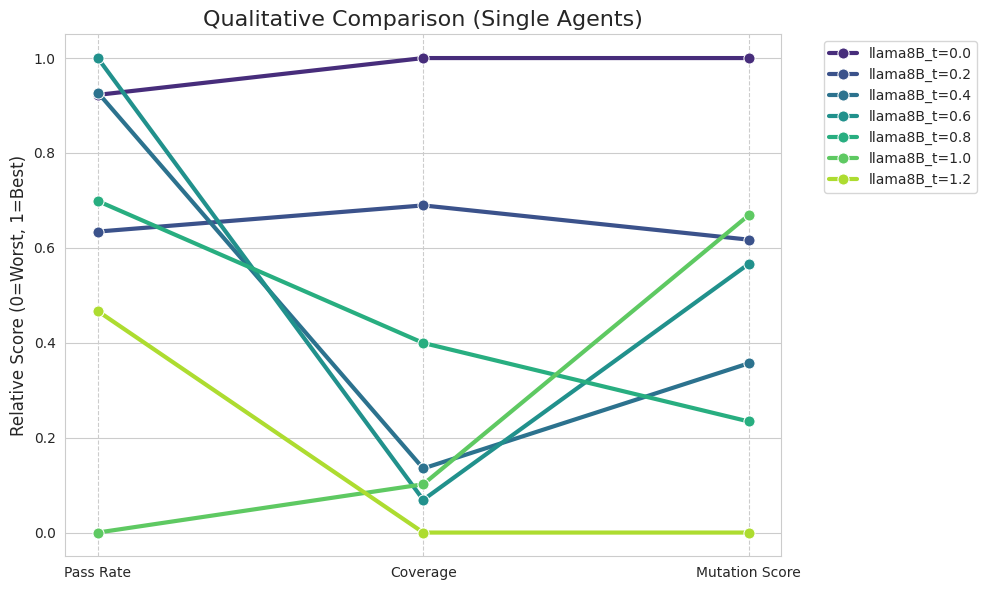

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import os

# Load data
df = pd.read_csv("all_metrics.csv")
# Filter out failed runs
df = df[df["status"] != "failed"]

# Filter Single Agents
df_single = df[df["experiment_name"].str.startswith("single_")].copy()

# Calculate Metrics
df_single["total_tests"] = df_single["n_passed_tests"] + df_single["n_failed_tests"]
df_single["pass_rate"] = df_single.apply(
    lambda row: (
        row["n_passed_tests"] / row["total_tests"] * 100
        if row["total_tests"] > 0
        else 0
    ),
    axis=1,
)

# Aggregate
metrics = ["pass_rate", "coverage_percent", "mutation_score_percent"]
agg_df = df_single.groupby("experiment_name")[metrics].mean().reset_index()

# Clean Names
agg_df["experiment_name"] = agg_df["experiment_name"].str.replace("single_", "")

# Normalize data for Parallel Coordinates (0-1 Scale)
scaler = MinMaxScaler()
df_norm = agg_df.copy()
df_norm[metrics] = scaler.fit_transform(agg_df[metrics])

# Rename columns for the plot
df_norm.columns = ["Agent", "Pass Rate", "Coverage", "Mutation Score"]

# Melt for plotting
df_melted = pd.melt(
    df_norm, id_vars="Agent", var_name="Metric", value_name="NormalizedScore"
)

# Plotting Parallel Coordinates Style using Lineplot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Draw the lines
sns.lineplot(
    data=df_melted,
    x="Metric",
    y="NormalizedScore",
    hue="Agent",
    palette="viridis",
    linewidth=3,
    marker="o",
    markersize=8,
)

# Formatting
plt.title("Qualitative Comparison (Single Agents)", fontsize=16)
plt.ylabel("Relative Score (0=Worst, 1=Best)", fontsize=12)
plt.xlabel("")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, axis="x", linestyle="--")

plt.tight_layout()
os.makedirs("report", exist_ok=True)
# plt.savefig("report/parallel_coordinates_quality_only.png")

## Baseline vs collaborative vs competitive

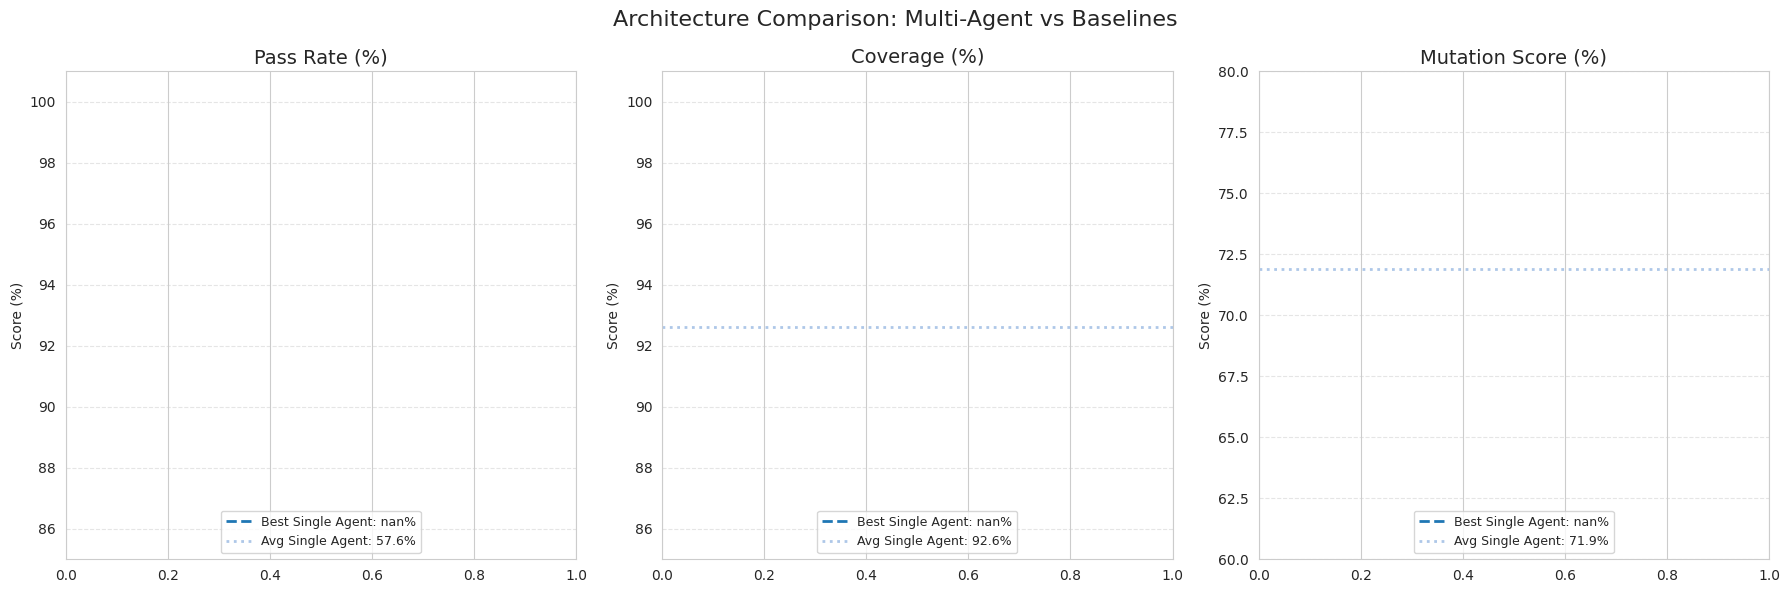

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
df = pd.read_csv("all_metrics.csv")
# Filter out failed runs
df = df[df["status"] != "failed"]

# Consistent color palette across charts
ARCH_COLORS = {
    "Single Agent": "#1f77b4",
    "Collaborative": "#2ca02c",
    "Competitive": "#ff7f0e",
}
BASELINE_COLORS = {
    "Best Single": "#1f77b4",
    "Avg Single": "#aec7e8",
}


# 1. Categorize experiments
def get_category(name):
    if name.startswith("single_"):
        return "Single Agent"
    elif name.startswith("collaborative_"):
        return "Collaborative"
    elif name.startswith("competitive_"):
        return "Competitive"
    return "Other"


df["category"] = df["experiment_name"].apply(get_category)

# 2. Calculate Metrics
df["total_tests"] = df["n_passed_tests"] + df["n_failed_tests"]
df["pass_rate"] = df.apply(
    lambda row: (
        row["n_passed_tests"] / row["total_tests"] * 100
        if row["total_tests"] > 0
        else 0
    ),
    axis=1,
)

# 3. Prepare Data for Multi-Agent (Collaborative & Competitive)
multi_agent_df = df[df["category"].isin(["Collaborative", "Competitive"])]

# 4. Prepare Data for Baselines
# Baseline 1: Best Single Agent (gptoss120B)
best_baseline_df = df[df["experiment_name"] == "single_gptoss120B"]
best_baseline_means = best_baseline_df[
    ["pass_rate", "coverage_percent", "mutation_score_percent"]
].mean()

# Baseline 2: Average of All Single Agents
avg_baseline_df = df[df["category"] == "Single Agent"]
avg_baseline_means = avg_baseline_df[
    ["pass_rate", "coverage_percent", "mutation_score_percent"]
].mean()

# 5. Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Architecture Comparison: Multi-Agent vs Baselines", fontsize=16)

metrics = [
    ("pass_rate", "Pass Rate (%)", 85, 101),
    ("coverage_percent", "Coverage (%)", 85, 101),
    ("mutation_score_percent", "Mutation Score (%)", 60, 80),
]

categories = ["Collaborative", "Competitive"]
colors = [ARCH_COLORS["Collaborative"], ARCH_COLORS["Competitive"]]

for i, (metric, title, ylim_min, ylim_max) in enumerate(metrics):
    ax = axes[i]

    # Baseline Values
    best_val = best_baseline_means[metric]
    avg_val = avg_baseline_means[metric]

    # Plot Bars with seaborn for confidence intervals
    sns.barplot(
        data=multi_agent_df,
        x="category",
        y=metric,
        hue="category",
        order=categories,
        hue_order=categories,
        palette=colors,
        ax=ax,
        errorbar=("ci", 95),
        capsize=0.1,
        alpha=0.8,
        legend=False,
    )

    # Plot Baseline Lines
    # Line 1: Best Baseline
    ax.axhline(
        y=best_val,
        color=BASELINE_COLORS["Best Single"],
        linestyle="--",
        linewidth=2,
        label=f"Best Single Agent: {best_val:.1f}%",
    )

    # Line 2: Average Baseline
    ax.axhline(
        y=avg_val,
        color=BASELINE_COLORS["Avg Single"],
        linestyle=":",
        linewidth=2,
        label=f"Avg Single Agent: {avg_val:.1f}%",
    )

    # Styling
    ax.set_title(title, fontsize=14)
    ax.set_ylim(ylim_min, ylim_max)
    ax.set_ylabel("Score (%)")
    ax.set_xlabel("")
    ax.grid(axis="y", linestyle="--", alpha=0.5)

    # Legend
    ax.legend(loc="lower center", fontsize=9)

plt.tight_layout()
# plt.savefig("report/multi_agent_vs_baselines_bars.png")

## Big vs mixed vs small (vs collaborative vs competitive vs single)

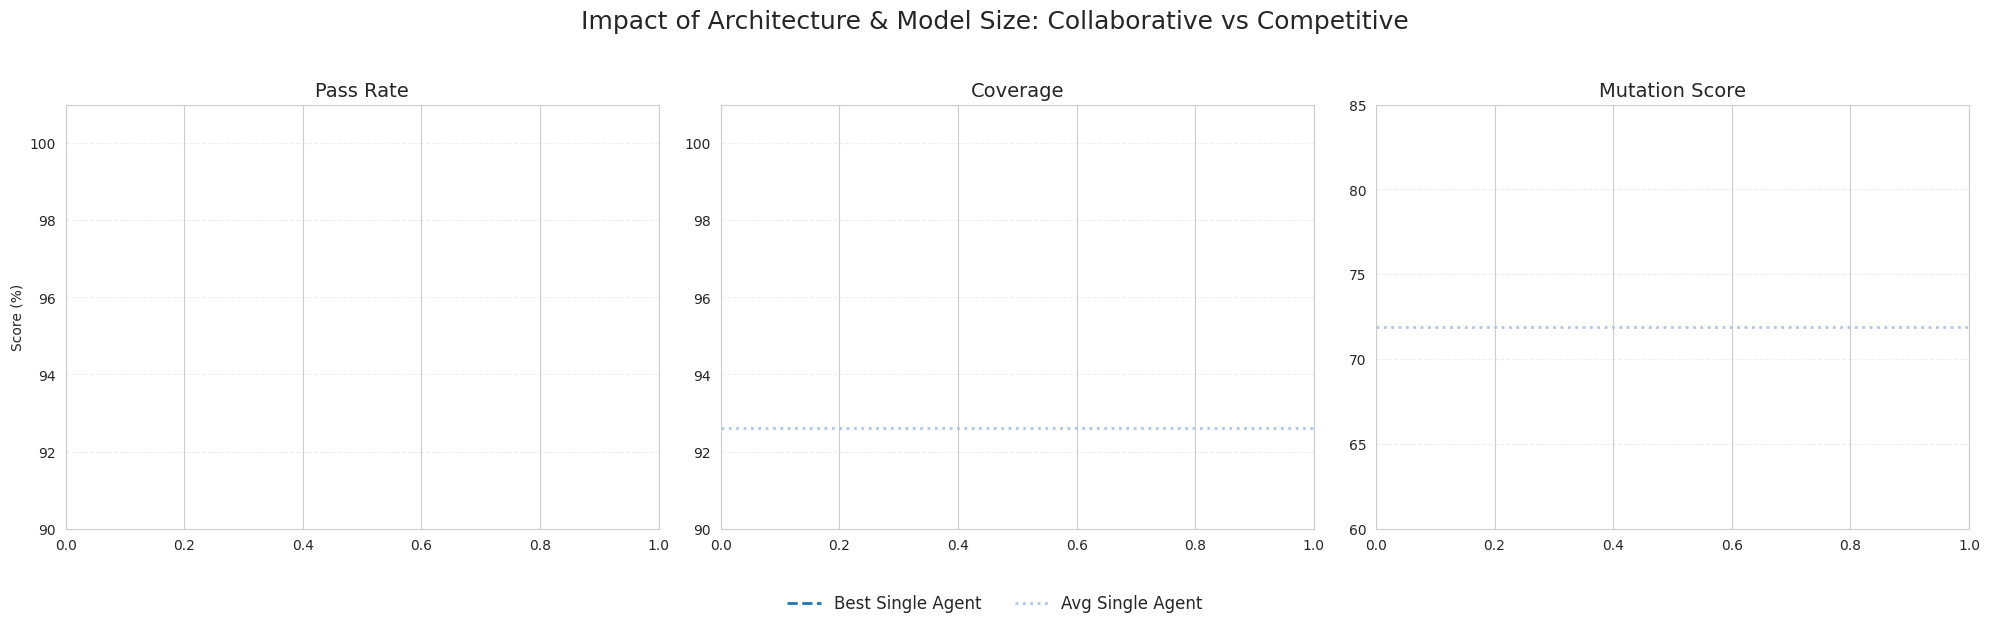

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("all_metrics.csv")
# Filter out failed runs
df = df[df["status"] != "failed"]

# Consistent color palette across charts
ARCH_COLORS = {
    "Single Agent": "#1f77b4",
    "Collaborative": "#2ca02c",
    "Competitive": "#ff7f0e",
}

# --- 1. Data Preparation & Classification ---

# Define Model Sizes
big_models = ["gptoss120B", "llama70B", "llama70b"]
small_models = [
    "llamascout17B",
    "llama8B",
    "gptoss20B",
    "llamascout17b",
    "gptoss20b",
]


def classify_experiment(exp_name):
    parts = exp_name.split("_")
    arch_type = parts[0]
    models = parts[1:]

    # 1. Architecture
    if arch_type == "single":
        return "Single Agent", None
    elif arch_type == "collaborative":
        architecture = "Collaborative"
    elif arch_type == "competitive":
        architecture = "Competitive"
    else:
        return "Other", None

    # 2. Composition
    has_big = False
    has_small = False

    for model in models:
        m_lower = model.lower()
        is_big = any(b.lower() in m_lower for b in big_models)
        is_small = any(s.lower() in m_lower for s in small_models)

        if is_big:
            has_big = True
        if is_small:
            has_small = True

    if has_big and not has_small:
        composition = "Big Only"
    elif has_small and not has_big:
        composition = "Small Only"
    elif has_big and has_small:
        composition = "Mixed (Big + Small)"
    else:
        composition = "Unknown"

    return architecture, composition


# Apply classification
df["Architecture"], df["Composition"] = zip(
    *df["experiment_name"].apply(classify_experiment)
)

# Metrics Calculation
df["total_tests"] = df["n_passed_tests"] + df["n_failed_tests"]
df["pass_rate"] = df.apply(
    lambda row: (
        row["n_passed_tests"] / row["total_tests"] * 100
        if row["total_tests"] > 0
        else 0
    ),
    axis=1,
)

# Rename for plotting
df = df.rename(
    columns={
        "pass_rate": "Pass Rate",
        "coverage_percent": "Coverage",
        "mutation_score_percent": "Mutation Score",
    }
)

metrics_list = ["Pass Rate", "Coverage", "Mutation Score"]

# --- 2. Calculate Baselines ---

# Best Single Agent (gptoss120B)
best_single_df = df[df["experiment_name"] == "single_gptoss120B"]
best_baselines = best_single_df[metrics_list].mean()

# Average Single Agent
avg_single_df = df[df["Architecture"] == "Single Agent"]
avg_baselines = avg_single_df[metrics_list].mean()

# --- 3. Filter Data for Plotting ---
# Keep only Multi-Agent rows with valid composition
plot_df = df[
    (df["Architecture"].isin(["Collaborative", "Competitive"]))
    & (df["Composition"] != "Unknown")
]

# --- 4. Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle(
    "Impact of Architecture & Model Size: Collaborative vs Competitive", fontsize=18
)

# Order for X-axis
comp_order = ["Big Only", "Mixed (Big + Small)", "Small Only"]
# Colors for Architecture
arch_palette = {
    "Collaborative": ARCH_COLORS["Collaborative"],
    "Competitive": ARCH_COLORS["Competitive"],
}

for i, metric in enumerate(metrics_list):
    ax = axes[i]

    # Plot Bar Chart
    sns.barplot(
        data=plot_df,
        x="Composition",
        y=metric,
        hue="Architecture",
        order=comp_order,
        hue_order=["Collaborative", "Competitive"],
        palette=arch_palette,
        ax=ax,
        errorbar=("ci", 95),  # Confidence Interval
        capsize=0.1,
    )

    # Add Baselines
    # Best Single
    ax.axhline(
        y=best_baselines[metric],
        color=ARCH_COLORS["Single Agent"],
        linestyle="--",
        linewidth=2,
        label=f"Best Single Agent",
    )
    # Avg Single
    ax.axhline(
        y=avg_baselines[metric],
        color="#aec7e8",
        linestyle=":",
        linewidth=2,
        label=f"Avg Single Agent",
    )

    # Styling
    ax.set_title(metric, fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("Score (%)" if i == 0 else "")

    # Y-Limits adjustment to make room for text/visuals
    if metric == "Pass Rate" or metric == "Coverage":
        ax.set_ylim(90, 101)
    else:  # Mutation Score
        ax.set_ylim(60, 85)

    ax.grid(axis="y", linestyle="--", alpha=0.3)

    # Legend handling: Only show in the last plot or bottom
    if i == 1:  # Center legend for shared info? Or just put it in the last one.
        # Let's put legend in the middle plot, below
        pass

    # Remove individual legends to create a unified one later or keep per plot if clean
    ax.legend().remove()

# Unified Legend
# Get handles/labels from one of the axes
handles, labels = axes[0].get_legend_handles_labels()
# Add baseline handles manually if not in barplot handles (axhline doesn't automatically add to seaborn legend usually, need to check)
# Actually, axhline labels are in ax.get_legend_handles_labels() if labeled.
h, l = axes[0].get_legend_handles_labels()
# h contains bars + lines.
# h[0:2] are bars, h[2:4] are lines usually.

fig.legend(
    h,
    l,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=4,
    fontsize=12,
    frameon=False,
)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Make space for legend
# plt.savefig("report/architecture_size_comparison_split.png")

## Efficiency

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Load Data
df = pd.read_csv("all_metrics.csv")
# Filter out failed runs
df = df[df["status"] != "failed"]

# Consistent color palette across charts
ARCH_COLORS = {
    "Single Agent": "#1f77b4",
    "Collaborative": "#2ca02c",
    "Competitive": "#ff7f0e",
}
EFFICIENCY_COLORS = {
    "Average": "#95a5a6",
    "Best": ARCH_COLORS["Single Agent"],
}

# 2. Metric Calculation
# Pass Rate
df["total_tests"] = df["n_passed_tests"] + df["n_failed_tests"]
df["pass_rate"] = df.apply(
    lambda row: (
        row["n_passed_tests"] / row["total_tests"] if row["total_tests"] > 0 else 0
    ),
    axis=1,
)

# File-Normalized Tokens (Relative Cost)
file_mean_tokens = df.groupby("file")["total_tokens"].transform("mean")
df["tokens_relative_cost"] = df["total_tokens"] / file_mean_tokens

# Relative Efficiency Score = (Quality / Cost)
# Quality = PassRate * Coverage * Mutation
# Cost = Normalized Tokens
df["efficiency"] = (
    df["pass_rate"]
    * df["coverage_percent"]
    * df["mutation_score_percent"]
    / df["tokens_relative_cost"]
)

# 3. Data Preparation for "Average" vs "Best" Comparison
categories = ["Single Agent", "Collaborative", "Competitive"]
plot_data = []


def get_category(name):
    if name.startswith("single_"):
        return "Single Agent"
    if name.startswith("collaborative_"):
        return "Collaborative"
    if name.startswith("competitive_"):
        return "Competitive"
    return "Other"


df["category"] = df["experiment_name"].apply(get_category)

combined_rows = []
for cat in categories:
    cat_df = df[df["category"] == cat]

    # "Average" Group: All runs in this category
    avg_rows = cat_df.copy()
    avg_rows["Condition"] = "Average"
    avg_rows["Architecture"] = cat
    combined_rows.append(avg_rows[["Architecture", "Condition", "efficiency"]])

    # "Best" Group: Runs from the single best experiment (highest mean efficiency)
    exp_means = cat_df.groupby("experiment_name")["efficiency"].mean()
    best_exp_name = exp_means.idxmax()
    best_rows = cat_df[cat_df["experiment_name"] == best_exp_name].copy()
    best_rows["Condition"] = "Best"
    best_rows["Architecture"] = cat
    combined_rows.append(best_rows[["Architecture", "Condition", "efficiency"]])

final_plot_df = pd.concat(combined_rows)

# 4. Plotting
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")
palette = {"Average": EFFICIENCY_COLORS["Average"], "Best": EFFICIENCY_COLORS["Best"]}

ax = sns.barplot(
    data=final_plot_df,
    x="Architecture",
    y="efficiency",
    hue="Condition",
    palette=palette,
    errorbar=("ci", 95),  # Confidence Interval
    capsize=0.1,
)


plt.title(
    "Efficiency Analysis: Average vs Best Configuration per Architecture", fontsize=16
)
plt.ylabel("Relative Efficiency Score\n(Quality / Relative Cost)", fontsize=12)
plt.xlabel("Architecture", fontsize=12)
plt.legend(title="Configuration")
plt.tight_layout()
# plt.savefig("report/efficiency_final.png")
plt.show()

ValueError: attempt to get argmax of an empty sequence

Single Agent Llama 8B - Aggregated by Temperature
 temperature  pass_rate  coverage_percent  mutation_score_percent  total_tokens  iterations
         0.0  61.424774         99.052632               81.946111    632.684211         0.0
         0.2  56.996032         96.000000               73.243684    692.550000         0.0
         0.4  61.501443         90.550000               67.191111    666.850000         0.0
         0.6  62.617424         89.900000               72.071579    653.300000         0.0
         0.8  57.986541         93.150000               64.481579    739.150000         0.0
         1.0  47.245625         90.222222               74.270000    698.277778         0.0
         1.2  54.420394         89.222222               58.399375    712.666667         0.0




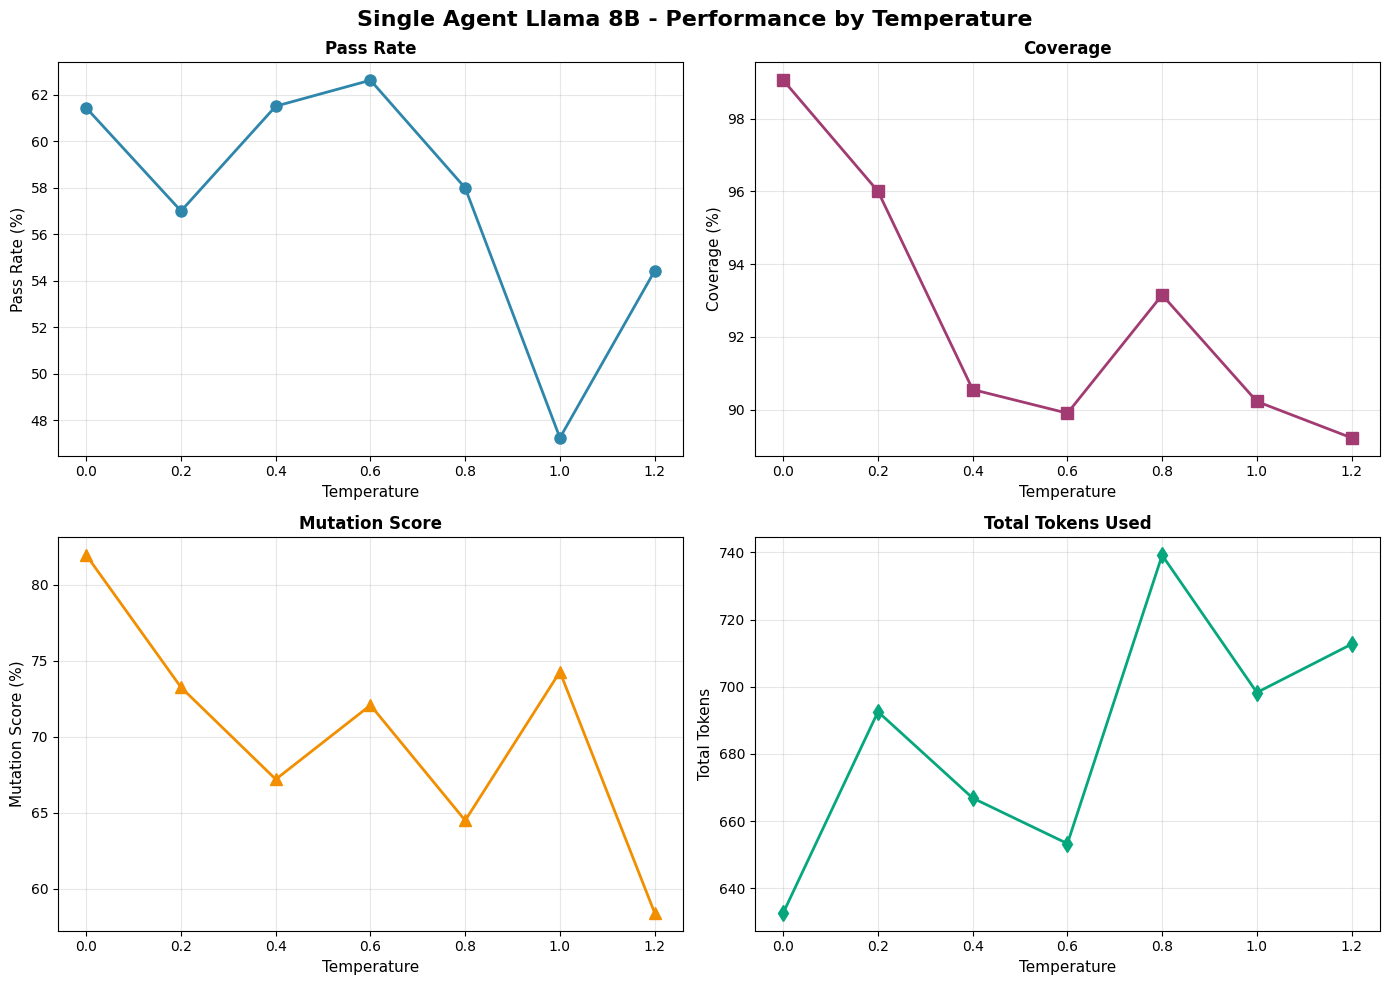

In [ ]:
# Aggregate Single Agent Llama 8B by Temperature
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("all_metrics.csv")
# Filter out failed runs
df = df[df["status"] != "failed"]

# Filter Single Agent Llama 8B runs
df_llama8b = df[df["experiment_name"].str.contains("single_llama8B", na=False)].copy()

# Calculate Metrics
df_llama8b["total_tests"] = df_llama8b["n_passed_tests"] + df_llama8b["n_failed_tests"]
df_llama8b["pass_rate"] = df_llama8b.apply(
    lambda row: (
        row["n_passed_tests"] / row["total_tests"] * 100
        if row["total_tests"] > 0
        else 0
    ),
    axis=1,
)

# Group by temperature and aggregate
metrics = [
    "pass_rate",
    "coverage_percent",
    "mutation_score_percent",
    "total_tokens",
    "iterations",
]
agg_by_temp = df_llama8b.groupby("temperature")[metrics].mean().reset_index()

# Display aggregated data
print("Single Agent Llama 8B - Aggregated by Temperature")
print("=" * 80)
print(agg_by_temp.to_string(index=False))
print("\n")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(
    "Single Agent Llama 8B - Performance by Temperature", fontsize=16, fontweight="bold"
)

# Plot 1: Pass Rate
axes[0, 0].plot(
    agg_by_temp["temperature"],
    agg_by_temp["pass_rate"],
    marker="o",
    linewidth=2,
    markersize=8,
    color="#2E86AB",
)
axes[0, 0].set_xlabel("Temperature", fontsize=11)
axes[0, 0].set_ylabel("Pass Rate (%)", fontsize=11)
axes[0, 0].set_title("Pass Rate", fontsize=12, fontweight="bold")
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Coverage
axes[0, 1].plot(
    agg_by_temp["temperature"],
    agg_by_temp["coverage_percent"],
    marker="s",
    linewidth=2,
    markersize=8,
    color="#A23B72",
)
axes[0, 1].set_xlabel("Temperature", fontsize=11)
axes[0, 1].set_ylabel("Coverage (%)", fontsize=11)
axes[0, 1].set_title("Coverage", fontsize=12, fontweight="bold")
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Mutation Score
axes[1, 0].plot(
    agg_by_temp["temperature"],
    agg_by_temp["mutation_score_percent"],
    marker="^",
    linewidth=2,
    markersize=8,
    color="#F18F01",
)
axes[1, 0].set_xlabel("Temperature", fontsize=11)
axes[1, 0].set_ylabel("Mutation Score (%)", fontsize=11)
axes[1, 0].set_title("Mutation Score", fontsize=12, fontweight="bold")
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Total Tokens
axes[1, 1].plot(
    agg_by_temp["temperature"],
    agg_by_temp["total_tokens"],
    marker="d",
    linewidth=2,
    markersize=8,
    color="#06A77D",
)
axes[1, 1].set_xlabel("Temperature", fontsize=11)
axes[1, 1].set_ylabel("Total Tokens", fontsize=11)
axes[1, 1].set_title("Total Tokens Used", fontsize=12, fontweight="bold")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()